# Preparation and data loading

In [1]:
# Import packages
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import pickle

#Import custom modules
sys.path.append('../')
from utils.utils import *

In [2]:
#Load data
all_data=pd.read_csv("../data/all_data_2015-2020.csv", index_col=0)
#Create datetime index
all_data.index = pd.to_datetime(all_data.index)
#Extract years
years = all_data["Year"].unique()
#Extract countries
countries = all_data["Country"].unique()
#Extract features 
features = all_data.columns

# Data Preprocessing

## Replace NaNs
Nans should be replaced for values where the country does not use the specific production unit
Replace with 0, because 0 kWh is generated

Create Loop to replace NaNs for production types that do not exist in the specific country with 0

In [3]:
data_summed=all_data.groupby(["Country"]).sum()
data_missing_prep = data_summed.copy().drop("Year",axis=1)
data_nan=data_missing_prep[data_missing_prep==0].dropna(axis=1, how="all")

for country in countries:
    columns = data_nan.loc[country][data_nan.loc[country]==0].index.to_list()
    all_data.loc[all_data["Country"]==country,columns]=0
    
#Save data so it can be used for analysis of missing values
#all_data.to_csv("../all_data_processed.csv")

In [4]:
all_data.head()

,Year,Country,Day_ahead_price,Load,Biomass,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,...,Other,Other renewable,Solar,Waste,Wind Onshore,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Nuclear,Wind Offshore,Fossil Peat
2015-01-01 00:00:00+00:00,2015,AT,88.20,6017.0,304.0,926.0,14.0,0.0,0.0,0.0,...,212.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,2015,AT,65.08,5751.0,304.0,756.0,14.0,0.0,0.0,0.0,...,266.0,0.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,2015,AT,46.82,5407.0,304.0,735.0,14.0,0.0,0.0,0.0,...,199.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,2015,AT,22.60,5285.0,304.0,724.0,14.0,0.0,0.0,0.0,...,172.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00+00:00,2015,AT,31.06,5280.0,304.0,724.0,14.0,0.0,0.0,0.0,...,273.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0


## Encoding year and country

In [5]:
# Year encoding
min_year=2015
all_data.loc[:,"Year"] = all_data.loc[:,"Year"]-min_year

In [6]:
#Country encoding
countries = all_data.loc[:,"Country"].unique()
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(countries)
all_data.loc[:,"Country"] = label_encoder.transform(all_data.loc[:,"Country"])

#Show list
country_codes = dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
country_codes

{'AT': 0,
 'BE': 1,
 'BG': 2,
 'CH': 3,
 'CZ': 4,
 'DE-AT-LU': 5,
 'DE-LU': 6,
 'DK': 7,
 'EE': 8,
 'ES': 9,
 'FI': 10,
 'FR': 11,
 'GB': 12,
 'GR': 13,
 'HR': 14,
 'HU': 15,
 'IE': 16,
 'IT': 17,
 'LT': 18,
 'LV': 19,
 'NL': 20,
 'NO': 21,
 'PL': 22,
 'PT': 23,
 'RO': 24,
 'RS': 25,
 'SE': 26,
 'SI': 27,
 'SK': 28}

## Encoding Weekday and Hour

In [7]:
#Add weekday
all_data.insert(1,"Weekday",all_data.index.weekday)
#Add hour
all_data.insert(2,"Hour",all_data.index.hour)

## Aggregate and rename features

In [8]:
#Other
other = ["Other", "Fossil Peat", "Other renewable", "Waste", "Fossil Oil", "Fossil Coal-derived gas", "Geothermal"]
all_data["Other"] = all_data[other].sum(axis=1)
all_data.drop(other[1:],axis=1, inplace=True)

#Hydro
hydro = ["Hydro Run-of-river and poundage", "Hydro Water Reservoir"]
all_data["Hydro"] = all_data[hydro].sum(axis=1)
all_data.drop(hydro, axis = 1, inplace = True)

In [9]:
#Rename
all_data.rename(columns = {"Fossil Brown coal/Lignite":"Lignite", "Solar":"PV",
                           "Fossil Hard coal": "Hard coal",
                           "Hydro Pumped Storage":"Pumped Storage"}, inplace=True)

In [17]:
dict(zip(all_data.columns[4:].tolist(), np.arange(0,13)))

{'Day_ahead_price': 0,
 'Load': 1,
 'Biomass': 2,
 'Fossil Gas': 3,
 'Hard coal': 4,
 'Pumped Storage': 5,
 'Other': 6,
 'PV': 7,
 'Wind Onshore': 8,
 'Lignite': 9,
 'Nuclear': 10,
 'Wind Offshore': 11,
 'Hydro': 12}

## Normalize data

In [37]:
#Save year, weekday, hour and country since they do not neet to be normalized
columns_to_save = all_data.iloc[:,0:4]
#Save mean and sd
mean = all_data.mean()
sd = all_data.std()
#Normalize
all_data = (all_data-mean)/sd
#Reset columns from earlier
all_data.iloc[:,0:4] = columns_to_save
#Save normalization
save_norm = [mean, sd]
with open("../data/data_normalization.pkl", "wb") as stream:
    pickle.dump(save_norm,stream)

## NaN encoding

In [38]:
df_nan = all_data.iloc[:,4:].copy()
df_nan[df_nan.isna()==False]=0
df_nan.fillna(1,inplace=True)
df_nan.columns = [col for col in df_nan.columns + "_nan"]

In [39]:
data_enc = pd.concat([all_data,df_nan],axis=1)

#Fill Nans
data_enc.fillna(0,inplace=True)

data_enc.head()

,Year,Weekday,Hour,Country,Day_ahead_price,Load,Biomass,Fossil Gas,Hard coal,Pumped Storage,...,Fossil Gas_nan,Hard coal_nan,Pumped Storage_nan,Other_nan,PV_nan,Wind Onshore_nan,Lignite_nan,Nuclear_nan,Wind Offshore_nan,Hydro_nan
2015-01-01 00:00:00+00:00,0,3,0,0,0.822994,-0.451792,-0.068995,-0.331468,-0.460221,-0.359091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,0,3,1,0,0.318383,-0.468543,-0.068995,-0.381799,-0.460221,-0.359091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,0,3,2,0,-0.080154,-0.490205,-0.068995,-0.388016,-0.460221,-0.359091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,0,3,3,0,-0.608773,-0.497888,-0.068995,-0.391273,-0.460221,-0.359091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00+00:00,0,3,4,0,-0.424127,-0.498202,-0.068995,-0.391273,-0.460221,-0.359091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Positional encoding
For most countries encoding is regular, for some countries it needs to be adjusted

Irregular countries : BG, RS, HR, DE-AT-LU, DE-LU

Create regular positional encoding

In [40]:
#Number of years
n_years = len(years)
#Number of days, including two gap years
n_days = 365*n_years + 2
#Number of hours, including two gap years
n_hours = 8760*n_years +48
#Position of gap year
gap_pos = [8760,(2*8760+24),(4*8760+8784)]

In [41]:
#Calculate the actual encoding for a normal year
n_hours_normal = 8760
pos_enc_normal = np.zeros([6,n_hours_normal])
for hour in range(n_hours_normal):
    #Day
    pos_enc_normal[0][hour] = np.sin(hour * np.pi*2 / 24)
    pos_enc_normal[1][hour] = np.cos(hour * np.pi*2 / 24)
    #Week
    pos_enc_normal[2][hour] = np.sin(hour * np.pi*2 / (7*24))
    pos_enc_normal[3][hour] = np.cos(hour * np.pi*2 / (7*24))
    #Year
    pos_enc_normal[4][hour] = np.sin(hour * np.pi*2 / (365*24))
    pos_enc_normal[5][hour] = np.cos(hour * np.pi*2 / (365*24))

In [42]:
#Calculate the actual encoding for a leap year
n_hours_leap = 8784
pos_enc_leap = np.zeros([6,n_hours_leap])
for hour in range(n_hours_leap):
    #Day
    pos_enc_leap[0][hour] = np.sin(hour * np.pi*2 / 24)
    pos_enc_leap[1][hour] = np.cos(hour * np.pi*2 / 24)
    #Week
    pos_enc_leap[2][hour] = np.sin(hour * np.pi*2 / (7*24))
    pos_enc_leap[3][hour] = np.cos(hour * np.pi*2 / (7*24))
    #Year
    pos_enc_leap[4][hour] = np.sin(hour * np.pi*2 / (366*24))
    pos_enc_leap[5][hour] = np.cos(hour * np.pi*2 / (366*24))

Manually combine leap years and normal years

In [43]:
pos_enc_full = np.concatenate([pos_enc_normal,pos_enc_leap,pos_enc_normal,pos_enc_normal,pos_enc_normal,pos_enc_leap],axis=1)
pos_enc_full.shape

(6, 52608)

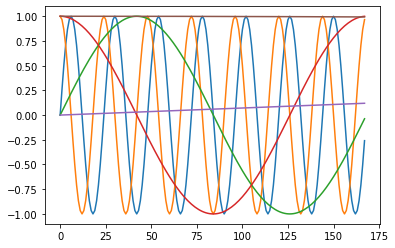

In [44]:
#Plot encoding
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(pos_enc_full.shape[0]):
    plt.plot(pos_enc_full[i][0:168])

### Create countries with missing years manually

In [45]:
#2015 is missing
pos_enc_bg = pos_enc_full[:,8760:]
#2015 is missing
pos_enc_rs = pos_enc_full[:,8760:]
#2015-2017 is missing
pos_enc_hr =  pos_enc_full[:,2*8760+8784:]
#Ends at position 32878, counting from 2015
pos_enc_de_at_lu = pos_enc_full[:,:32878]
#Starts at position 32854, counting from 2015
pos_enc_de_lu = pos_enc_full[:,32854:]

In [46]:
#Concatenate the whole positional encoding
pos_enc = np.concatenate([np.tile(pos_enc_full,2),pos_enc_bg,np.tile(pos_enc_full,2),pos_enc_de_at_lu,
                         pos_enc_de_lu,np.tile(pos_enc_full,7),pos_enc_hr,np.tile(pos_enc_full,10),
                         pos_enc_rs,np.tile(pos_enc_full,3)],axis=1)
pos_enc.shape

(6, 1429224)

### Append positional coding to data

In [47]:
data_enc = pd.concat([data_enc.reset_index(),pd.DataFrame(np.transpose(pos_enc))],axis=1)
data_enc.index=data_enc["index"]
data_enc.drop("index",axis=1,inplace=True)

# Create train/test split

Create subset of countries to simplify calculations (for now)

In [48]:
#subset_countries = np.random.choice(list(country_codes.values()),3,replace=False)
#print(subset_countries)
#data_enc = data_enc[data_enc["Country"].isin(subset_countries)]

Take random months of countries as test set

In [49]:
# Add month to data
data_enc.insert(4,"Month",data_enc.index.month-1)

In [50]:
data_enc

,Year,Weekday,Hour,Country,Month,Day_ahead_price,Load,Biomass,Fossil Gas,Hard coal,...,Lignite_nan,Nuclear_nan,Wind Offshore_nan,Hydro_nan,0,1,2,3,4,5
index,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0,3,0,0,0,0.822994,-0.451792,-0.068995,-0.331468,-0.460221,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 01:00:00+00:00,0,3,1,0,0,0.318383,-0.468543,-0.068995,-0.381799,-0.460221,...,0.0,0.0,0.0,0.0,0.258819,0.965926,0.037391,0.999301,0.000717,1.000000
2015-01-01 02:00:00+00:00,0,3,2,0,0,-0.080154,-0.490205,-0.068995,-0.388016,-0.460221,...,0.0,0.0,0.0,0.0,0.500000,0.866025,0.074730,0.997204,0.001435,0.999999
2015-01-01 03:00:00+00:00,0,3,3,0,0,-0.608773,-0.497888,-0.068995,-0.391273,-0.460221,...,0.0,0.0,0.0,0.0,0.707107,0.707107,0.111964,0.993712,0.002152,0.999998
2015-01-01 04:00:00+00:00,0,3,4,0,0,-0.424127,-0.498202,-0.068995,-0.391273,-0.460221,...,0.0,0.0,0.0,0.0,0.866025,0.500000,0.149042,0.988831,0.002869,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,5,3,19,28,11,-0.000708,-0.640834,-0.285617,-0.421176,-0.465570,...,0.0,0.0,0.0,0.0,-0.965926,0.258819,0.999301,-0.037391,-0.003576,0.999994
2020-12-31 20:00:00+00:00,5,3,20,28,11,-0.047634,-0.647068,-0.284528,-0.427689,-0.465570,...,0.0,0.0,0.0,0.0,-0.866025,0.500000,0.997204,-0.074730,-0.002861,0.999996
2020-12-31 21:00:00+00:00,5,3,21,28,11,-0.060511,-0.650972,-0.283439,-0.467066,-0.465570,...,0.0,0.0,0.0,0.0,-0.707107,0.707107,0.993712,-0.111964,-0.002146,0.999998


In [51]:
split_ratio = 0.1

test_df =data_enc.iloc[:,0:4].copy()
test_df["Month"] = test_df.index.month
test_df.drop(["Hour","Weekday"],axis=1,inplace=True)
test_df.drop_duplicates(inplace=True)

split = int(np.round(split_ratio*len(test_df)))

sample_df = test_df.sample(split)

Extract train/test set from data

In [52]:
#Function to create rolling window
def create_rolling_window(data, window = 7):
    n_days = int(data.shape[0]/24)
    input_data = []
    for day in range(n_days):
        if day >= 0 and day < n_days-(window-1):
            input_data.append(data[(day*24):(day+window)*24])
    input_data = np.array(input_data)
    return(input_data)

In [53]:
#Reset index
data_enc.reset_index(inplace=True)

In [54]:
# An dieser Stelle schon testdaten transformieren und zusätzlich index speichern um trainingsdaten zu transformieren
index_list = list()
first = True

for x in range(len(sample_df)):
    sample = sample_df.iloc[x,]
    sample_data = data_enc[(data_enc["Year"]==sample["Year"])&(data_enc["Month"]+1==sample["Month"])&(data_enc["Country"]==sample["Country"])]
    index = sample_data.index
    index_list.extend(index)
    if first==True:
        testing_data_reshaped = create_rolling_window(np.array(sample_data),window=5)
        first=False
    else:
        testing_data_reshaped = np.append(testing_data_reshaped,create_rolling_window(np.array(sample_data),window=5),axis=0)

In [55]:
#Index extrahieren
testing_index = testing_data_reshaped[:,:,0]
testing_data_reshaped = testing_data_reshaped[:,:,1:]

In [56]:
#Index aus Trainingsdaten löschen
training_data = data_enc.iloc[:,1:].copy()
training_data["Test_data"]=0
training_data.loc[training_data.index.isin(index_list),"Test_data"] = 1

Funktionen um Daten zu transformieren

In [57]:
def create_rolling_window_train(data, window = 7):
    n_days = int(data.shape[0]/24)
    input_data = []
    for day in range(n_days):
        if day >= 0 and day < n_days-(window-1):
            data_subset = data[(day*24):(day+window)*24]
            if 1 not in data_subset[:,-1]:
                input_data.append(data_subset[:,:-1])

    input_data = np.array(input_data)
    return(input_data)

In [58]:
#Conplete function to transform data
def transform_data(data, countries, window=7):
    #Variable to check for the first loop iteration
    first = True
    
    for country in countries:
        df = data[data["Country"]==country]
        data_array = np.array(df)
        data_array = create_rolling_window_train(data_array,window)

        #Check if its the first iteration
        if first ==True:
            data_reshaped = data_array
            first=False        
        else:
            data_reshaped = np.append(data_reshaped,data_array,axis=0)
            
    return data_reshaped

In [59]:
training_data_reshaped = transform_data(data = training_data, countries = training_data["Country"].unique(),window=5)

# Save data

Create feature information

In [60]:
#Need to change
countries = np.array(list(country_codes.values()))
years = data_enc["Year"].unique()
feature_names = all_data.columns[4:]
no_features = len(feature_names)

feature_information = [countries, years, feature_names, no_features]

In [61]:
#Save reshaped training and testing data
np.save("../data/training_data_reshaped",training_data_reshaped.astype("float32"))
np.save("../data/testing_data_reshaped",testing_data_reshaped.astype("float32"))

#Save testing index
np.save("../data/testing_data_index",testing_index)

#Save information
with open("../data/data_information.pkl", "wb") as p:
    pickle.dump(feature_information, p)